### USING MOBILENET

In [ ]:
from google.colab import drive
drive.mount('/content/drive')                                                                                                                                                                                                                                                                                                                                                                                                                                         

Mounted at /content/drive


In [ ]:
!pip install torchsummary
import pandas as pd
import numpy as np
import torch 
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchsummary import summary
import seaborn as sns
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix, roc_curve, auc
from scipy import interp
from tqdm import tqdm_notebook as tqdm
import time
import warnings
warnings.simplefilter("ignore")

In [ ]:
trainig_path = '/content/drive/My Drive/Brain-Tumor-Classification/Training/'
testing_path = '/content/drive/My Drive/Brain-Tumor-Classification/Testing/'

IMAGE_SIZE=(128,128)
batch_size=64
learning_rate = 0.0008
epochs=50
num_classes=3

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
def images_transforms(phase):
    if phase == 'training':
        data_transformation = transforms.Compose([
            transforms.Resize(IMAGE_SIZE),
#             transforms.RandomEqualize(10),
            transforms.RandomRotation(degrees=(-25,20)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
        ])
    else:
        data_transformation=transforms.Compose([
            transforms.Resize(IMAGE_SIZE),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
        ])
        
    
    return data_transformation

In [ ]:
trainset=datasets.ImageFolder(trainig_path,transform=images_transforms('training'))
testset=datasets.ImageFolder(testing_path,transform=images_transforms('test'))
testset, valset = torch.utils.data.random_split(testset, [119, 175])

In [ ]:
train_loader = DataLoader(trainset,batch_size=batch_size,shuffle=True,num_workers=2)
test_loader = DataLoader(testset,batch_size=batch_size,shuffle=True,num_workers=2)
val_loader = DataLoader(valset,batch_size=batch_size,shuffle=True,num_workers=2)

In [ ]:
def imshow(img):
    plt.figure(figsize=(20, 20))
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


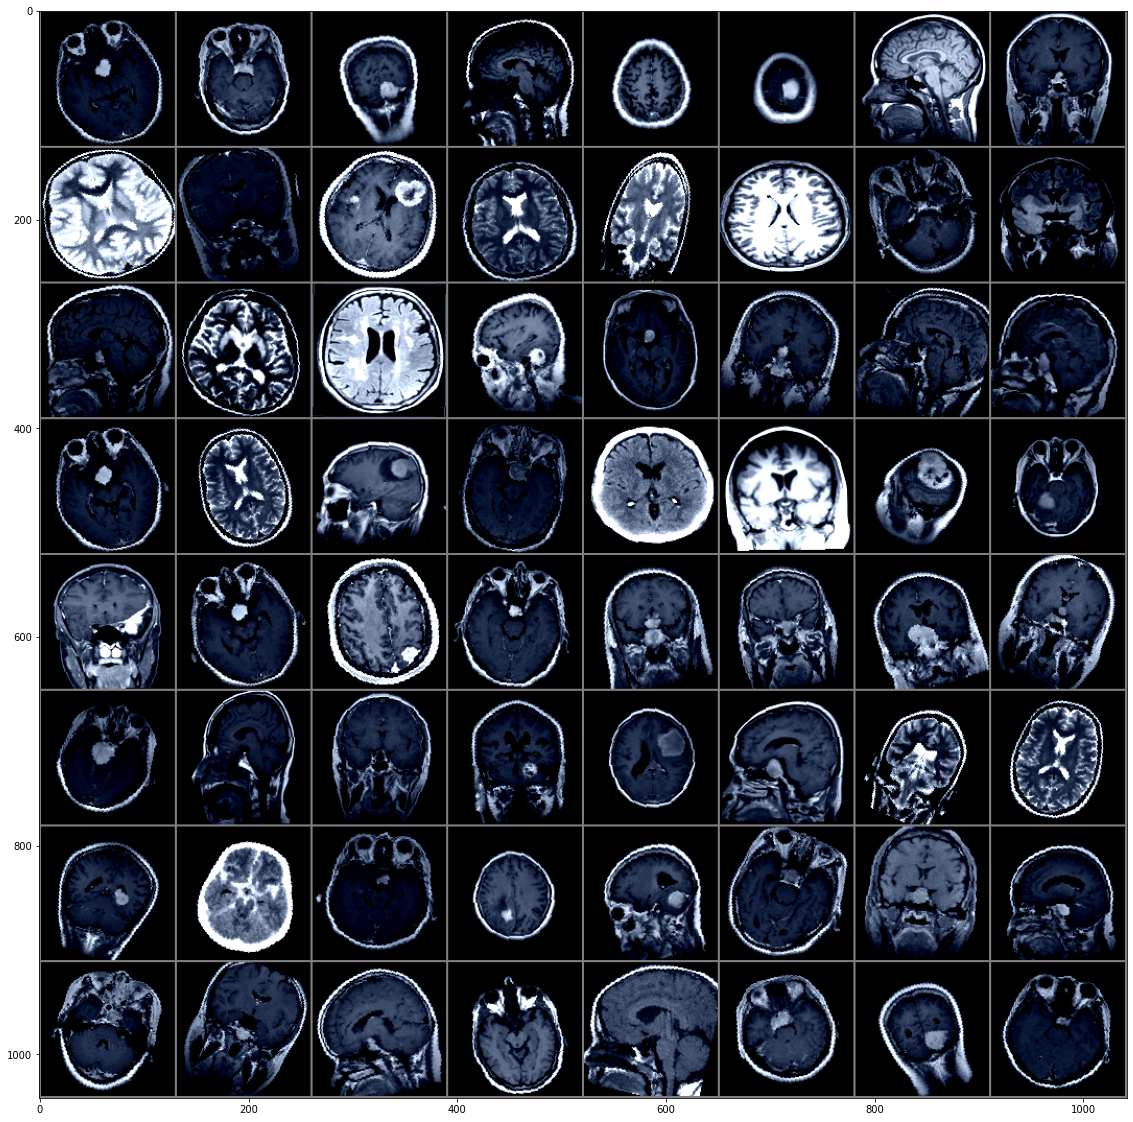

In [ ]:
examples = iter(train_loader)
images,labels = examples.next()
imshow(torchvision.utils.make_grid(images))

In [ ]:
model=torchvision.models.mobilenet_v3_large(pretrained=True)
num_features=model.classifier[0].in_features
model.classifier=nn.Sequential(
    nn.Linear(in_features=num_features, out_features=4096, bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=4096, out_features=4096, bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=4096, out_features=num_classes, bias=True)
  )

Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth


  0%|          | 0.00/21.1M [00:00<?, ?B/s]

In [ ]:
model=model.to(device)
criterion=nn.CrossEntropyLoss()
optimizer = torch.optim.Adamax(model.parameters(),lr=learning_rate)

In [ ]:
IMAGE_SIZE=(3,)+IMAGE_SIZE
print(summary(model,IMAGE_SIZE))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 64, 64]             432
       BatchNorm2d-2           [-1, 16, 64, 64]              32
         Hardswish-3           [-1, 16, 64, 64]               0
            Conv2d-4           [-1, 16, 64, 64]             144
       BatchNorm2d-5           [-1, 16, 64, 64]              32
              ReLU-6           [-1, 16, 64, 64]               0
            Conv2d-7           [-1, 16, 64, 64]             256
       BatchNorm2d-8           [-1, 16, 64, 64]              32
  InvertedResidual-9           [-1, 16, 64, 64]               0
           Conv2d-10           [-1, 64, 64, 64]           1,024
      BatchNorm2d-11           [-1, 64, 64, 64]             128
             ReLU-12           [-1, 64, 64, 64]               0
           Conv2d-13           [-1, 64, 32, 32]             576
      BatchNorm2d-14           [-1, 64,

In [ ]:
def test(model,testloader):
    with torch.no_grad():
        n_correct=0
        n_samples=0
        y_pred=[]
        y_actual=[]
        for i,(images,labels) in enumerate(testloader):
            images=images.to(device)
            labels=labels.to(device)
            
            outputs=model(images)
            
            y_actual+=list(np.array(labels.detach().to('cpu')).flatten())
        # value ,index
            _,predictes=torch.max(outputs,1)
            y_pred+=list(np.array(predictes.detach().to('cpu')).flatten())
        # number of samples in current batch
            n_samples+=labels.shape[0]

            n_correct+= (predictes==labels).sum().item()
            
        y_actual=np.array(y_actual).flatten()
        y_pred=np.array(y_pred).flatten()
        print(np.unique(y_pred))
        acc = classification_report(y_actual,y_pred,target_names=trainset.classes)

        #confusion matrix
        LABELS = ['Meningioma', 'Pitutary','No Tumor']
        arr = confusion_matrix(y_actual,y_pred)
        df_cm = pd.DataFrame(arr, LABELS, LABELS)
        plt.figure(figsize = (9,6))
        sns.heatmap(df_cm, annot=True, fmt="d", cmap='viridis')
        plt.xlabel("Prediction")
        plt.ylabel("Target")
        plt.show()

        print(f"{acc}")

def print_roc_curve(y_test, y_score, n_classes, figsize = (8, 6)):
    lw = 2
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    fig = plt.figure(figsize=figsize)
    """
    plt.plot(fpr["micro"], tpr["micro"],
            label='micro-average ROC curve (area = {0:0.2f})'
                    ''.format(roc_auc["micro"]),
            color='deeppink', linestyle=':', linewidth=4)
    """
    plt.plot(fpr["macro"], tpr["macro"],
            label='macro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_auc["macro"]),
            color='navy', linestyle=':', linewidth=4)
    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    #plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    return fig



In [ ]:
def train(model,train_loader,criterion,optimizer,val_loader,epochs=25):
    train_losses = []
    val_losses = []
    train_auc = []
    val_auc = []
    train_auc_epoch = []
    val_auc_epoch = []
    best_acc = 0.0
    min_loss = np.Inf

    since = time.time()
    y_actual=[]
    y_pred=[]
    for e in range(epochs):
        y_actual=[]
        y_pred=[]
        train_loss = 0.0
        val_loss = 0.0

        # Train the model
        model.train()
        for i, (images, labels) in enumerate(tqdm(train_loader, total=int(len(train_loader)))):
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Loss and accuracy
            train_loss += loss.item()
            
            _,predictes=torch.max(outputs,1)
            y_actual += list(labels.data.cpu().numpy().flatten()) 
            y_pred += list(predictes.detach().cpu().numpy().flatten())
        train_auc.append(accuracy_score(y_actual, y_pred))

        # Evaluate the model
        model.eval()
        for i, (images, labels) in enumerate(tqdm(val_loader, total=int(len(val_loader)))):
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Loss and accuracy
            val_loss += loss.item()
            _,predictes=torch.max(outputs,1)
            y_actual += list(labels.data.cpu().numpy().flatten()) 
            y_pred += list(predictes.detach().cpu().numpy().flatten())
        
        val_auc.append(accuracy_score(y_actual, y_pred))

        # Average losses and accuracies
        train_loss = train_loss/len(train_loader)
        val_loss = val_loss/len(val_loader)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        training_auc = train_auc[-1]
        validation_auc = val_auc[-1]
        train_auc_epoch.append(training_auc)
        val_auc_epoch.append(validation_auc)

        # Updating best validation accuracy
        if best_acc < validation_auc:
            best_acc = validation_auc

        # Saving best model
        if min_loss >= val_loss:
            torch.save(model.state_dict(), 'best_model.pt')
            min_loss = val_loss

        print('EPOCH {}/{} Train loss: {:.6f},Validation loss: {:.6f}, Train AUC: {:.4f}  Validation AUC: {:.4f}\n  '.format(e+1, epochs,train_loss,val_loss, training_auc,validation_auc))
        print('-' * 10)
    time_elapsed = time.time() - since
    print('Training completed in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best validation accuracy: {:4f}'.format(best_acc))
    return train_losses,val_losses,train_auc ,val_auc,train_auc_epoch,val_auc_epoch

In [ ]:
train_losses,val_losses,train_auc ,val_auc,train_auc_epoch,val_auc_epoch=train(model,train_loader,criterion,optimizer,val_loader,epochs)

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH 1/50 Train loss: 0.411772,Validation loss: 0.646787, Train AUC: 0.8552  Validation AUC: 0.8477
  
----------


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH 2/50 Train loss: 0.118920,Validation loss: 0.409494, Train AUC: 0.9560  Validation AUC: 0.9509
  
----------


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH 3/50 Train loss: 0.064109,Validation loss: 0.236964, Train AUC: 0.9746  Validation AUC: 0.9707
  
----------


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH 4/50 Train loss: 0.043508,Validation loss: 0.178646, Train AUC: 0.9853  Validation AUC: 0.9824
  
----------


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH 5/50 Train loss: 0.033102,Validation loss: 0.230189, Train AUC: 0.9883  Validation AUC: 0.9815
  
----------


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH 6/50 Train loss: 0.022045,Validation loss: 0.256223, Train AUC: 0.9917  Validation AUC: 0.9851
  
----------


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH 7/50 Train loss: 0.027765,Validation loss: 0.385005, Train AUC: 0.9912  Validation AUC: 0.9833
  
----------


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH 8/50 Train loss: 0.011792,Validation loss: 0.407903, Train AUC: 0.9961  Validation AUC: 0.9878
  
----------


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH 9/50 Train loss: 0.009357,Validation loss: 0.344567, Train AUC: 0.9971  Validation AUC: 0.9901
  
----------


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH 10/50 Train loss: 0.013106,Validation loss: 0.415559, Train AUC: 0.9946  Validation AUC: 0.9878
  
----------


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH 11/50 Train loss: 0.036722,Validation loss: 0.418537, Train AUC: 0.9887  Validation AUC: 0.9824
  
----------


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH 12/50 Train loss: 0.023917,Validation loss: 0.401472, Train AUC: 0.9927  Validation AUC: 0.9829
  
----------


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH 13/50 Train loss: 0.012725,Validation loss: 0.158569, Train AUC: 0.9966  Validation AUC: 0.9919
  
----------


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH 14/50 Train loss: 0.004544,Validation loss: 0.147391, Train AUC: 0.9980  Validation AUC: 0.9955
  
----------


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH 15/50 Train loss: 0.008019,Validation loss: 0.159420, Train AUC: 0.9976  Validation AUC: 0.9955
  
----------


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH 16/50 Train loss: 0.012460,Validation loss: 0.672832, Train AUC: 0.9956  Validation AUC: 0.9865
  
----------


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH 17/50 Train loss: 0.006974,Validation loss: 0.462223, Train AUC: 0.9976  Validation AUC: 0.9901
  
----------


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH 18/50 Train loss: 0.006753,Validation loss: 0.327613, Train AUC: 0.9985  Validation AUC: 0.9923
  
----------


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH 19/50 Train loss: 0.013265,Validation loss: 0.146981, Train AUC: 0.9961  Validation AUC: 0.9932
  
----------


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH 20/50 Train loss: 0.009715,Validation loss: 0.291192, Train AUC: 0.9956  Validation AUC: 0.9892
  
----------


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH 21/50 Train loss: 0.010601,Validation loss: 0.280756, Train AUC: 0.9971  Validation AUC: 0.9910
  
----------


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH 22/50 Train loss: 0.005283,Validation loss: 0.210949, Train AUC: 0.9980  Validation AUC: 0.9919
  
----------


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH 23/50 Train loss: 0.003446,Validation loss: 0.239881, Train AUC: 0.9985  Validation AUC: 0.9937
  
----------


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH 24/50 Train loss: 0.009410,Validation loss: 0.386040, Train AUC: 0.9966  Validation AUC: 0.9901
  
----------


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH 25/50 Train loss: 0.010181,Validation loss: 0.203685, Train AUC: 0.9966  Validation AUC: 0.9910
  
----------


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH 26/50 Train loss: 0.001900,Validation loss: 0.263935, Train AUC: 1.0000  Validation AUC: 0.9937
  
----------


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH 27/50 Train loss: 0.004101,Validation loss: 0.260393, Train AUC: 0.9990  Validation AUC: 0.9928
  
----------


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH 28/50 Train loss: 0.003986,Validation loss: 0.309758, Train AUC: 0.9985  Validation AUC: 0.9919
  
----------


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH 29/50 Train loss: 0.002658,Validation loss: 0.335142, Train AUC: 0.9995  Validation AUC: 0.9928
  
----------


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH 30/50 Train loss: 0.008223,Validation loss: 0.186232, Train AUC: 0.9985  Validation AUC: 0.9928
  
----------


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH 31/50 Train loss: 0.001055,Validation loss: 0.318038, Train AUC: 1.0000  Validation AUC: 0.9919
  
----------


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH 32/50 Train loss: 0.000531,Validation loss: 0.312423, Train AUC: 1.0000  Validation AUC: 0.9923
  
----------


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH 33/50 Train loss: 0.001169,Validation loss: 0.362526, Train AUC: 0.9995  Validation AUC: 0.9919
  
----------


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH 34/50 Train loss: 0.000897,Validation loss: 0.291723, Train AUC: 1.0000  Validation AUC: 0.9932
  
----------


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH 35/50 Train loss: 0.003371,Validation loss: 0.295436, Train AUC: 0.9990  Validation AUC: 0.9928
  
----------


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH 36/50 Train loss: 0.001075,Validation loss: 0.402048, Train AUC: 0.9995  Validation AUC: 0.9928
  
----------


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH 37/50 Train loss: 0.001382,Validation loss: 0.401287, Train AUC: 0.9995  Validation AUC: 0.9923
  
----------


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH 38/50 Train loss: 0.003999,Validation loss: 0.481874, Train AUC: 0.9990  Validation AUC: 0.9923
  
----------


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH 39/50 Train loss: 0.001808,Validation loss: 0.409331, Train AUC: 0.9990  Validation AUC: 0.9932
  
----------


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH 40/50 Train loss: 0.000556,Validation loss: 0.388747, Train AUC: 1.0000  Validation AUC: 0.9946
  
----------


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH 41/50 Train loss: 0.001704,Validation loss: 0.330115, Train AUC: 0.9995  Validation AUC: 0.9941
  
----------


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH 42/50 Train loss: 0.003673,Validation loss: 0.339367, Train AUC: 0.9985  Validation AUC: 0.9923
  
----------


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH 43/50 Train loss: 0.001055,Validation loss: 0.373681, Train AUC: 1.0000  Validation AUC: 0.9946
  
----------


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH 44/50 Train loss: 0.000927,Validation loss: 0.282105, Train AUC: 0.9995  Validation AUC: 0.9932
  
----------


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH 45/50 Train loss: 0.002689,Validation loss: 0.293517, Train AUC: 0.9990  Validation AUC: 0.9919
  
----------


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH 46/50 Train loss: 0.006663,Validation loss: 0.497134, Train AUC: 0.9976  Validation AUC: 0.9901
  
----------


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH 47/50 Train loss: 0.006393,Validation loss: 0.326083, Train AUC: 0.9976  Validation AUC: 0.9914
  
----------


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH 48/50 Train loss: 0.002786,Validation loss: 0.492599, Train AUC: 0.9990  Validation AUC: 0.9928
  
----------


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH 49/50 Train loss: 0.000398,Validation loss: 0.587352, Train AUC: 1.0000  Validation AUC: 0.9937
  
----------


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH 50/50 Train loss: 0.004695,Validation loss: 0.228048, Train AUC: 0.9980  Validation AUC: 0.9919
  
----------
Training completed in 10m 35s
Best validation accuracy: 0.995493


[0 1 2]


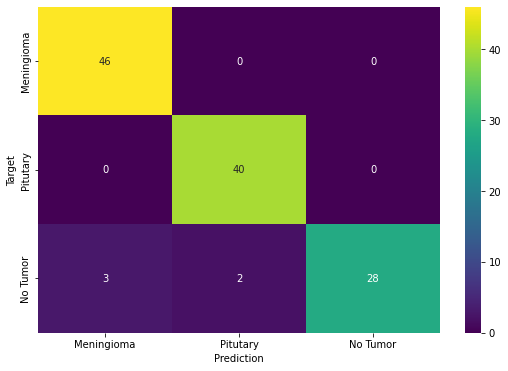

                  precision    recall  f1-score   support

meningioma_tumor       0.94      1.00      0.97        46
        no_tumor       0.95      1.00      0.98        40
 pituitary_tumor       1.00      0.85      0.92        33

        accuracy                           0.96       119
       macro avg       0.96      0.95      0.95       119
    weighted avg       0.96      0.96      0.96       119



In [ ]:
torch.save(model.state_dict(), '/content/drive/My Drive/Brain-Tumor-Classification/mobilenet_model.pt')
test(model,test_loader)

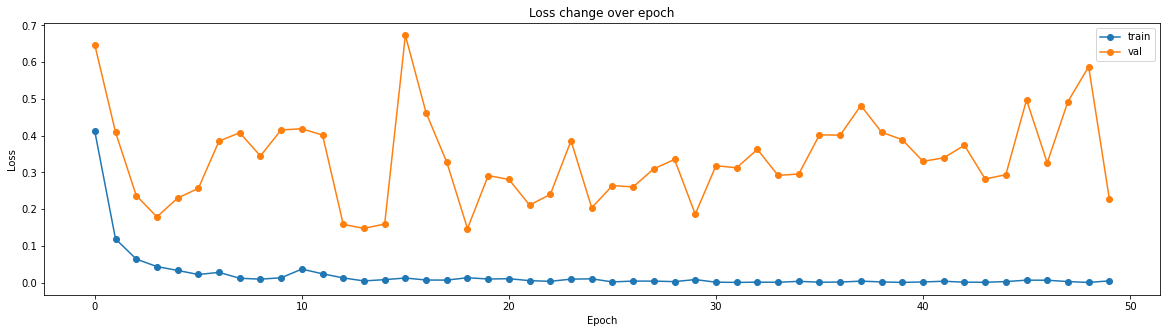

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(train_losses, '-o', label="train")
plt.plot(val_losses, '-o', label="val")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss change over epoch")
plt.legend()

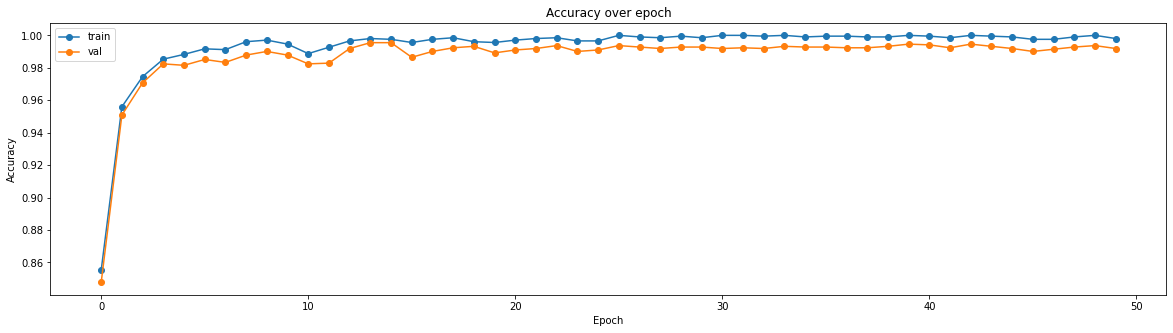

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(train_auc_epoch, '-o', label="train")
plt.plot(val_auc_epoch, '-o', label="val")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy over epoch")
plt.legend()